In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as lin
from keras.datasets import mnist
from matplotlib import pyplot as plt
import time
from cs771 import plotData as pd

Using TensorFlow backend.


In [3]:
# Learn a single (general) Gaussian per class
def learnClassConditionalDist( X, y ):
    (labels, labelCounts) = np.unique( y, return_counts = True )
    C = labels.size
    (n, d) = X.shape
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) )
    for c in range( C ):
        XThisLabel = X[y == c]
        # MLE for mean is simply the empirical mean (aka sample mean) of feature vectors of this class
        muVals[c] = np.mean( XThisLabel, axis = 0 )
        XCent = XThisLabel - muVals[c]
        # MLE for covariance matrix is simply the empirical/sample covariance matrix of this class
        SigmaVals[c] = 1/labelCounts[c]*(XCent.T).dot( XCent )
    return (C, list( zip( muVals, SigmaVals, np.arange( C ), labelCounts/n ) ))

# Stretch out the 28 x 28 image into a 784 dimensional vector
def flattenTensor( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    return X.reshape( n, d )

def predictClassScores( X, mu, Sigma, p, mask = [] ):
    # If no mask was provided, then we need to consider all coordinates of the feature vector
    if len(mask) == 0:
        mask = np.ones( (X.shape[1],), dtype=bool )
    
    XCent = X[:,mask] - mu[mask]
    
    # The covariance matrix will mostly be non-invertible in this case -- just set SLogDet = 0
    SLogDet = 0
    
    # Use the Moore-Penrose pseudoinverse to invert the matrix
    SInv = lin.pinv( Sigma[mask,:][:,mask] )

    # This term gives us (ignoring additive constants) ln P[x | y, \theta]
    term1 = 0.5 * (-SLogDet - np.sum( np.multiply( np.dot(XCent, SInv), XCent), axis = 1 ))
    # This term gives us ln P[y | \theta]
    term2 = np.log( p )
    
    return term1 + term2

def predictGen( X, model, C, mask = [] ):
    classScores = np.zeros( (X.shape[0], C) )
    for mu, Sigma, c, p in model:
        classScores[:,c] = predictClassScores( X, mu, Sigma, p, mask )
    return np.argmax( classScores, axis = 1 )

((XTrain, yTrain), (XTest, yTest)) = mnist.load_data()

# Normalize data coordinates otherwise numbers in later calculations explode
# Also, flatten images for sake of convenience
imShape = XTrain.shape[1:]
XTrainFlat = flattenTensor( XTrain/256 )
XTestFlat = flattenTensor( XTest/256 )

tic = time.perf_counter()
(C, model) = learnClassConditionalDist( XTrainFlat, yTrain )
toc = time.perf_counter()
print( "Full-rank Training Time: %0.3f seconds" % (toc - tic) )
tic = time.perf_counter()
yPred = predictGen( XTestFlat, model, C )
toc = time.perf_counter()
print( "Full-rank Prediction Time: %0.3f seconds " % (toc - tic) )
print( "Full-rank Prediction Accuracy: ", sum(yPred == yTest)/yTest.size )

Full-rank Training Time: 1.715 seconds
Full-rank Prediction Time: 10.613 seconds 
Full-rank Prediction Accuracy:  0.8573


Low-rank (k = 784) Training Time: 14.840 seconds
Low-rank (k = 784) Prediction Time: 5.454 seconds 
Low-rank (k = 784) Prediction Accuracy:  0.8573


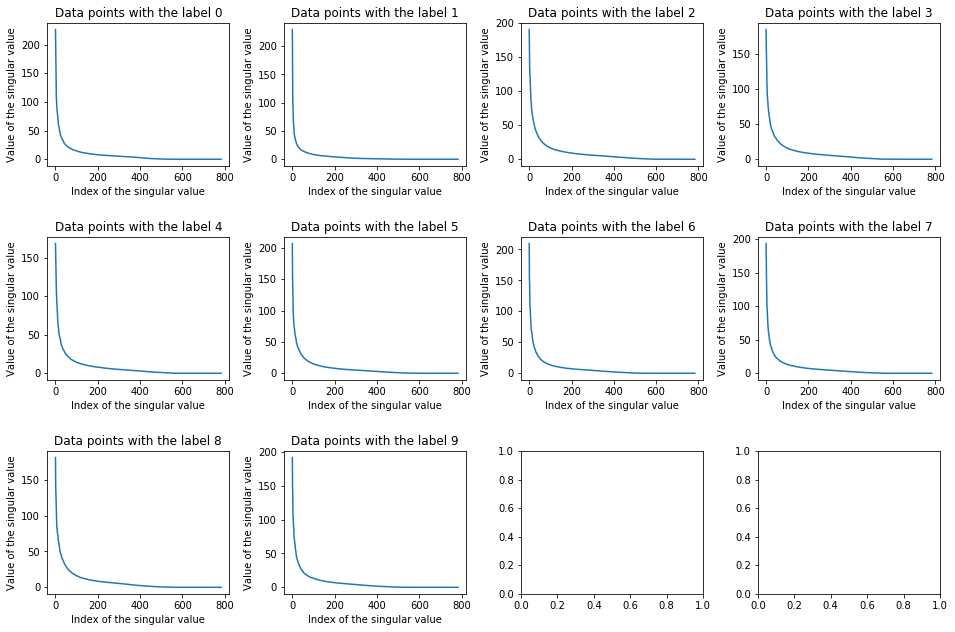

In [4]:
# Learn a single (low-rank) Gaussian per class
def learnLowRankClassConditionalDist( X, y, k, axs ):
    (labels, labelCounts) = np.unique( y, return_counts = True )
    C = labels.size
    (n, d) = X.shape
    
    muVals = np.zeros( (C, d) )
    singularValsInv = np.zeros( (C, k) )
    singularVecs = np.zeros( (C, k, d) )
    
    for c in range( C ):
        XThisLabel = X[y == c]
        muVals[c] = np.mean( XThisLabel, axis = 0 )
        D = XThisLabel - muVals[c]
        # Perform thin SVD on mean centered matrix i.e. on the matrix D = X - 1  mu.T
        # to get hold of a decomposition of the form U * S * V.T
        (U, S, VT) = lin.svd( D, full_matrices = False )
        
        # Let us see what the singular values look like and identify knee points
        axs[c].plot( S )
        axs[c].set_xlabel( "Index of the singular value" )
        axs[c].set_ylabel( "Value of the singular value" )
        axs[c].set_title( "Data points with the label %d" % c )
        
        # We are intersted in the (pseudo) inverse of the matrix C = 1/n * D.T * D
        # since C is the covariance matrix that appears in the Mahalanobis distance
        
        # We know that D = U * S * V.T. This means that the Moore-Penrose inverse of C is
        # n * V * S+ * S+ * V.T where S+ is the pseudo inverse of the diagonal matrix S
        S2 = np.square( S ) / labelCounts[c]
        largeSValIdx = S2 > 1e-15 * np.amax( S2 )
        S2Inv = np.divide( 1, S2, where = largeSValIdx )
        S2Inv[~largeSValIdx] = 0
        
        # Keep only the k largest inverted values -- be careful that since singular values in
        # S were ordered left to right, the inverses S+ will now be ordered right to left
        singularValsInv[c] = np.sqrt( S2Inv[-k:] )
        singularVecs[c] = VT[-k:]
    return (C, list( zip( muVals, singularValsInv, singularVecs, np.arange( C ), labelCounts, labelCounts/n ) ))

def predictLowRankClassScores( X, mu, SInv, V, n, p, k, mask = [] ):
    # If no mask was provided, then we need to consider all coordinates of the feature vector
    if len(mask) == 0:
        mask = np.ones( (X.shape[1],), dtype=bool )
    
    # Center the test points
    XCent = X[:, mask] - mu[mask]
    V = V[:, mask]
    
    # Take only the k components to approximate the inverse covariance
    # Be careful that inverted singular values are present in decreasing order
    V = V[-k:]
    SInv = SInv[-k:]
    
    # The new covariance matrix will mostly be low rank so its determinant would be zero
    SLogDet = 0
    
    # Calculating the Mahalanobis distance with this pseudo inverse is also easy
    # x' * (Sigma)^-1 * x = ||(S^-1 * V')x||_2^2
    # This term gives us (ignoring additive constants) ln P[x | y, \theta]
    term1 = 0.5 * (-SLogDet - np.sum( np.square( np.dot( XCent, V.T * SInv ) ), axis = 1))
    
    # This term gives us ln P[y | \theta]
    term2 = np.log( p )
    
    return term1 + term2

def predictLowRankGen( X, model, C, k, mask = [] ):
    classScores = np.zeros( (X.shape[0], C) )
    for mu, SInv, V, c, n, p in model:
        classScores[:,c] = predictLowRankClassScores( X, mu, SInv, V, n, p, k, mask )
    return np.argmax( classScores, axis = 1 )

k = np.prod( imShape )
fig, axs = pd.getFigList( nrows = 3, ncols = 4, sizex = 4, sizey = 3.5 )
plt.subplots_adjust( wspace = 0.3, hspace = 0.5 )

# Training time for low-rank models may go up since SVD etc are not cheap operations
# However, this is done to ensure smaller model sizes and smaller prediction times
tic = time.perf_counter()
(C, model) = learnLowRankClassConditionalDist( XTrainFlat, yTrain, k, axs )
toc = time.perf_counter()
print( "Low-rank (k = %d) Training Time: %0.3f seconds" % (k, (toc - tic)) )

# You would observe that using the "low-rank" model gives faster prediction even if
# we set the rank to equal to dimensionality of the features i.e. k = d = np.prod( imShape )
# This is because the naive solution computes the Mahalanobis distances using the formula
# np.multiply( np.dot(XCent, SInv), XCent) which involves two matrix matrix multiplications
# whereas the low-rank solution computes the Mahalanobis distances using the formulat
# np.square( np.dot( XCent, V.T * SInv ) ) which effectively involves just one matrix-matrix
# multiplication since the matrix SInv in this case is a diagonal matrix
tic = time.perf_counter()
yPred = predictLowRankGen( XTestFlat, model, C, k )
toc = time.perf_counter()
print( "Low-rank (k = %d) Prediction Time: %0.3f seconds " % (k, (toc - tic)) )
print( "Low-rank (k = %d) Prediction Accuracy: " % k, sum(yPred == yTest)/yTest.size )

In [5]:
kPred = 400

# With smaller rank, prediction time is sped up much more but there may be a reduction
# in prediction accuracy too since the Mahalanobis distances are getting distorted
# A tradeoff needs to be found between accuracy and prediction time/model size
tic = time.perf_counter()
yPred = predictLowRankGen( XTestFlat, model, C, kPred )
toc = time.perf_counter()
print( "Low-rank (k = %d) Prediction Time: %0.3f seconds " % (kPred, (toc - tic)) )
print( "Low-rank (k = %d) Prediction Accuracy: " % kPred, sum(yPred == yTest)/yTest.size )

Low-rank (k = 400) Prediction Time: 3.330 seconds 
Low-rank (k = 400) Prediction Accuracy:  0.789
